# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

In [3]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [4]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [5]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

# Dataset

In [8]:
df = pd.read_csv("diabetes.csv")

# Target's Analysis

In [9]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

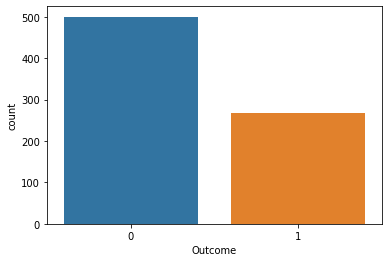

In [10]:
sns.countplot(x="Outcome", data=df)
plt.show()

In [11]:
100 * df["Outcome"].value_counts() / len(df)

0   65.104
1   34.896
Name: Outcome, dtype: float64

# Analysis of Features

In [12]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21        0
4            0      137             40             35      168 43.100                     2.288   33        1

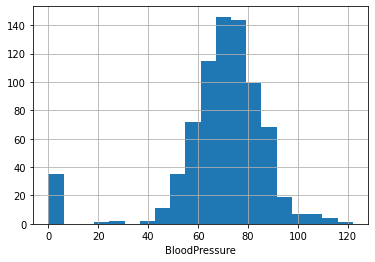

In [13]:
df["BloodPressure"].hist(bins=20)
plt.xlabel("BloodPressure")
plt.show()

In [14]:
def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)

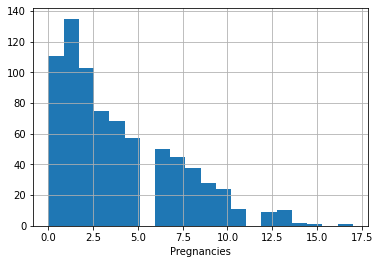

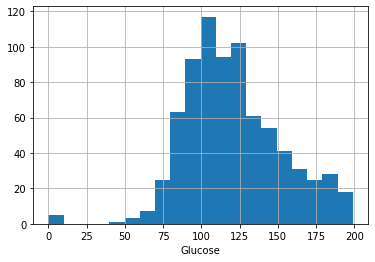

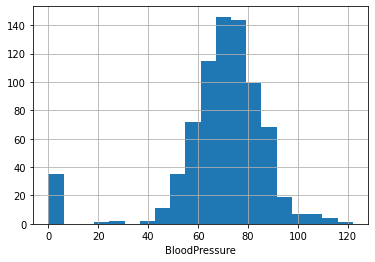

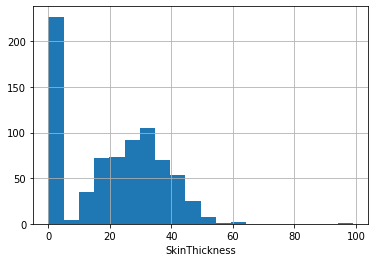

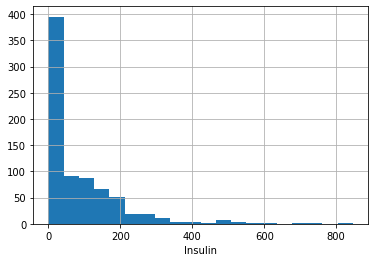

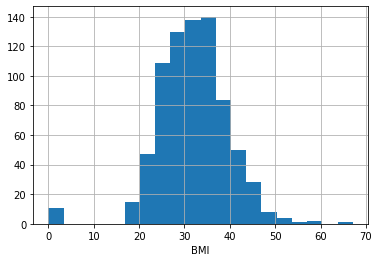

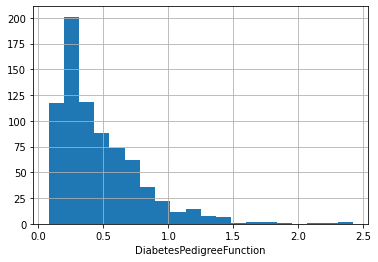

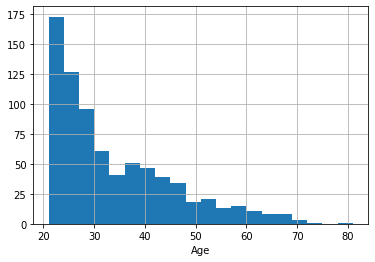

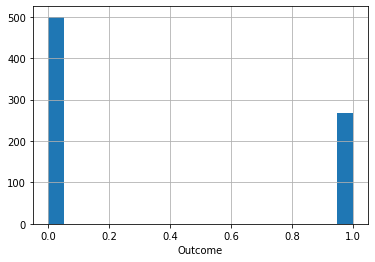

In [15]:
for col in df.columns:
    plot_numerical_col(df, col)

In [16]:
cols = [col for col in df.columns if "Outcome" not in col]

In [17]:
df.describe().T

count    mean     std    min    25%     50%     75%     max
Pregnancies              768.000   3.845   3.370  0.000  1.000   3.000   6.000  17.000
Glucose                  768.000 120.895  31.973  0.000 99.000 117.000 140.250 199.000
BloodPressure            768.000  69.105  19.356  0.000 62.000  72.000  80.000 122.000
SkinThickness            768.000  20.536  15.952  0.000  0.000  23.000  32.000  99.000
Insulin                  768.000  79.799 115.244  0.000  0.000  30.500 127.250 846.000
BMI                      768.000  31.993   7.884  0.000 27.300  32.000  36.600  67.100
DiabetesPedigreeFunction 768.000   0.472   0.331  0.078  0.244   0.372   0.626   2.420
Age                      768.000  33.241  11.760 21.000 24.000  29.000  41.000  81.000
Outcome                  768.000   0.349   0.477  0.000  0.000   0.000   1.000   1.000

# Target vs Features

In [18]:
df.groupby("Outcome").agg({"Pregnancies": "mean"})

Pregnancies
Outcome             
0              3.298
1              4.866

In [19]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [20]:
for col in cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




# Data Preprocessing

In [21]:
df.shape
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21        0
4            0      137             40             35      168 43.100                     2.288   33        1

In [22]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [23]:
df.describe().T

count    mean     std    min    25%     50%     75%     max
Pregnancies              768.000   3.845   3.370  0.000  1.000   3.000   6.000  17.000
Glucose                  768.000 120.895  31.973  0.000 99.000 117.000 140.250 199.000
BloodPressure            768.000  69.105  19.356  0.000 62.000  72.000  80.000 122.000
SkinThickness            768.000  20.536  15.952  0.000  0.000  23.000  32.000  99.000
Insulin                  768.000  79.799 115.244  0.000  0.000  30.500 127.250 846.000
BMI                      768.000  31.993   7.884  0.000 27.300  32.000  36.600  67.100
DiabetesPedigreeFunction 768.000   0.472   0.331  0.078  0.244   0.372   0.626   2.420
Age                      768.000  33.241  11.760 21.000 24.000  29.000  41.000  81.000
Outcome                  768.000   0.349   0.477  0.000  0.000   0.000   1.000   1.000

In [24]:
for col in cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [25]:
replace_with_thresholds(df, "Insulin")

In [26]:
for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

In [27]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction    Age  Outcome
0        0.600    0.752          0.000          0.375   -0.240  0.172                     0.665  1.235        1
1       -0.400   -0.776         -0.333          0.188   -0.240 -0.581                    -0.056  0.118        0
2        1.000    1.600         -0.444         -0.719   -0.240 -0.935                     0.783  0.176        1
3       -0.400   -0.679         -0.333          0.000    0.499 -0.419                    -0.537 -0.471        0
4       -0.600    0.485         -1.778          0.375    1.081  1.194                     5.008  0.235        1

# Model & Prediction

In [28]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [31]:
log_model = LogisticRegression().fit(X, y)

log_model.intercept_
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [32]:
y_pred = log_model.predict(X)

In [33]:
y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [34]:
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

# Model Evaluation

In [35]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

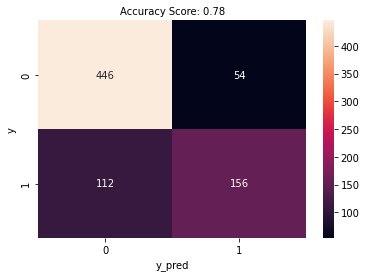

In [36]:
plot_confusion_matrix(y, y_pred)

In [37]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



# ROC AUC

In [38]:
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8393955223880598

# Model Validation: Holdout

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)

In [40]:
log_model = LogisticRegression().fit(X_train, y_train)

In [41]:
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


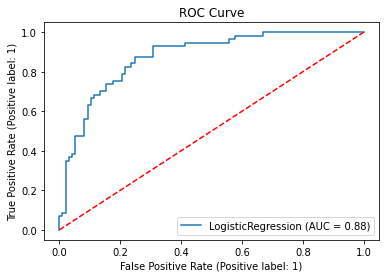

In [43]:
plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

# AUC

In [44]:
roc_auc_score(y_test, y_prob)

0.8755652016639537

# Model Validation: 10-Fold Cross Validation

In [45]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [46]:
log_model = LogisticRegression().fit(X, y)

In [47]:
cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [48]:
cv_results['test_accuracy'].mean()

0.7721925133689839

In [49]:
cv_results['test_precision'].mean()

0.7192472060223519

In [50]:
cv_results['test_recall'].mean()

0.5747030048916841

In [51]:
cv_results['test_f1'].mean()

0.6371421090986309

In [52]:
cv_results['test_roc_auc'].mean()

0.8327295597484277

# Prediction for A New Observation

In [53]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

In [54]:
random_user = X.sample(1, random_state=45)
log_model.predict(random_user)

array([1])